# Ray-based attenuation tomography

Ray-based attenuation tomography is a classical tomographic inversion method in seismology. Here we apply the same idea to ice-penetrating radar and investigate if we can directly resolve the conductivity structure over the ice depth, as opposed to a depth-averaged value. The advantage of a ray-based tomography is that it is much more computationally efficient (and easier to program) than full waveform inversion (FWI). There is, however, many limitations, one of which is that it only models frequency-independent attenuation. We will incorporate centroid frequency shift based tomography to account for frequency-dependent phenomenon later on.

Ray-based attenuation tomography assumes that the propagating wave can be considered as a ray (essentially a high-frequency approximation such that the source wavelength is much shorter than the layer spacing), therefore the abstraction removes the complexity of phase and waveform deformation. The only variables we care about are the wave velocity (here not considered either; in glaciology the radar wave speed is generally assumed a depth-averaged constant) and power attenuation. At plane-wave approximation, the power of the returning electric field strength is

\begin{equation}
    \mathbf{E} = \underbrace{e^{-\alpha z}}_\text{attenuation} \overbrace{e^{i\beta z}}^\text{phase}
    \label{plane wave}
\end{equation}

The attenuation constant $\alpha$ is 
\begin{equation}
    \alpha = \sqrt{\mu_o \omega \sigma/2}
\end{equation}

Assume a discretized layered ice model with uniform layer spacing $\Delta z$. The initial electric field strenghth at the surface is $E_o$, and the attenuation at layer $i$ is $\alpha_i$. The total attenuation of the signal at depth $z_q$ is
\begin{align}
    E(z_q) =  & E_0 e^{-\alpha_1 \Delta z} e^{-\alpha_2 \Delta z} ...e^{-\alpha_q \Delta z}\\  = & E_o \Pi_0^q [e^{-\alpha_i \Delta z}] \\ = & E_o e^{-\sum_0^q \alpha_i \Delta z}
    \label{eq:forward-model}
\end{align}

Therefore we can write an objective function that minimizes the differences between observed electric field strength from layer reflections and ray-based simulation using the equation above. We can now write: 

\begin{equation}
    J = \underbrace{\sum_0^H \text{log}_{10} \left(\frac{E_o e^{-\sum_0^q \alpha_i(\sigma) \Delta z} + \epsilon}{E_{obs} +  \epsilon}  \right)^2}_\text{data misfit} + \alpha \overbrace{\sum_0^H \left(\frac{d \sigma}{dz}  \right)^2}^\text{Regularization}  
\end{equation}

Notice here we 1. use the log10 misfit to measure data mismatch, and 2. add a regularization to enforce smoothness.

18


Text(0, 0.5, 'depth from ice surface (m)')

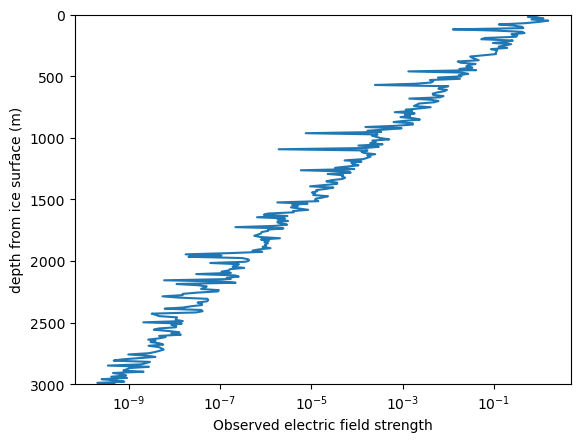

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Constants
depth = 3000  # meters
nz = 300  # number of depth points
z = np.linspace(0, depth, nz)
dz = z[1] - z[0]

# True conductivity model (example)
true_model = 1e-5 + 1e-5 * np.exp(-z/1000) + 1e-6 * np.random.randn(nz)

# Frequency of the radar
freq = 1e6  # 1 MHz
omega = 2 * np.pi * freq

# Forward model: NEEDS REVISION - it should be frequency independent
def forward_model(conductivity):
    mu0 = 4 * np.pi * 1e-7  # magnetic permeability of free space
    alpha = np.sqrt(mu0 * omega * conductivity / 2)
    attenuation = np.exp(-np.cumsum(alpha) * dz)
    return attenuation

# Generate synthetic observed data (with some noise)
true_field = forward_model(true_model)
noise_level = 0.7  # 50% noise
observed_field = true_field * (1 + noise_level * np.random.randn(nz))
print(sum(observed_field<0))

# treat the negative values
observed_field[observed_field<=0] = np.nan
mask = np.isnan(observed_field)
observed_field[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), observed_field[~mask])


fig, ax = plt.subplots()
ax.semilogx(observed_field, z)
ax.set_ylim(depth, 0)
ax.set_xlabel('Observed electric field strength')
ax.set_ylabel('depth from ice surface (m)')

In [16]:
# Objective function for inversion with smoothness constraint in log space
def objective(conductivity, observed, alpha):
    epsilon = 1e-11
    predicted = forward_model(conductivity)
    # data_misfit = np.sum((np.log10((predicted+epsilon)/(observed+epsilon)))**2)
    data_misfit = (1/predicted.size)*np.sum((np.log10(predicted + epsilon) - np.log10(observed + epsilon))**2)
    # data_misfit = np.sum((predicted - observed) ** 2)
    smoothness = alpha * np.sum(np.diff(conductivity)**2)
    return data_misfit + smoothness

# Inversion
initial_guess = np.ones(nz) * np.mean(true_model)

# Function to perform inversion with a given alpha
def invert(alpha):
    result = minimize(
        lambda x: objective(x, observed_field, alpha),
        initial_guess,
        method='L-BFGS-B',
        bounds=[(1e-6, 1e-3)]*nz
    )
    return result.x

# Try different alpha values
alphas = [1e9, 1e10,1e11, 4e11] # this is for log10 objective function
# alphas = [1e0, 1e2, 1e4, 1e6]
inverted_models = [invert(alpha) for alpha in alphas]


Alpha = 1000000000.0
Log10 RMSE: 0.071092

Alpha = 10000000000.0
Log10 RMSE: 0.058868

Alpha = 100000000000.0
Log10 RMSE: 0.089948

Alpha = 400000000000.0
Log10 RMSE: 0.089948


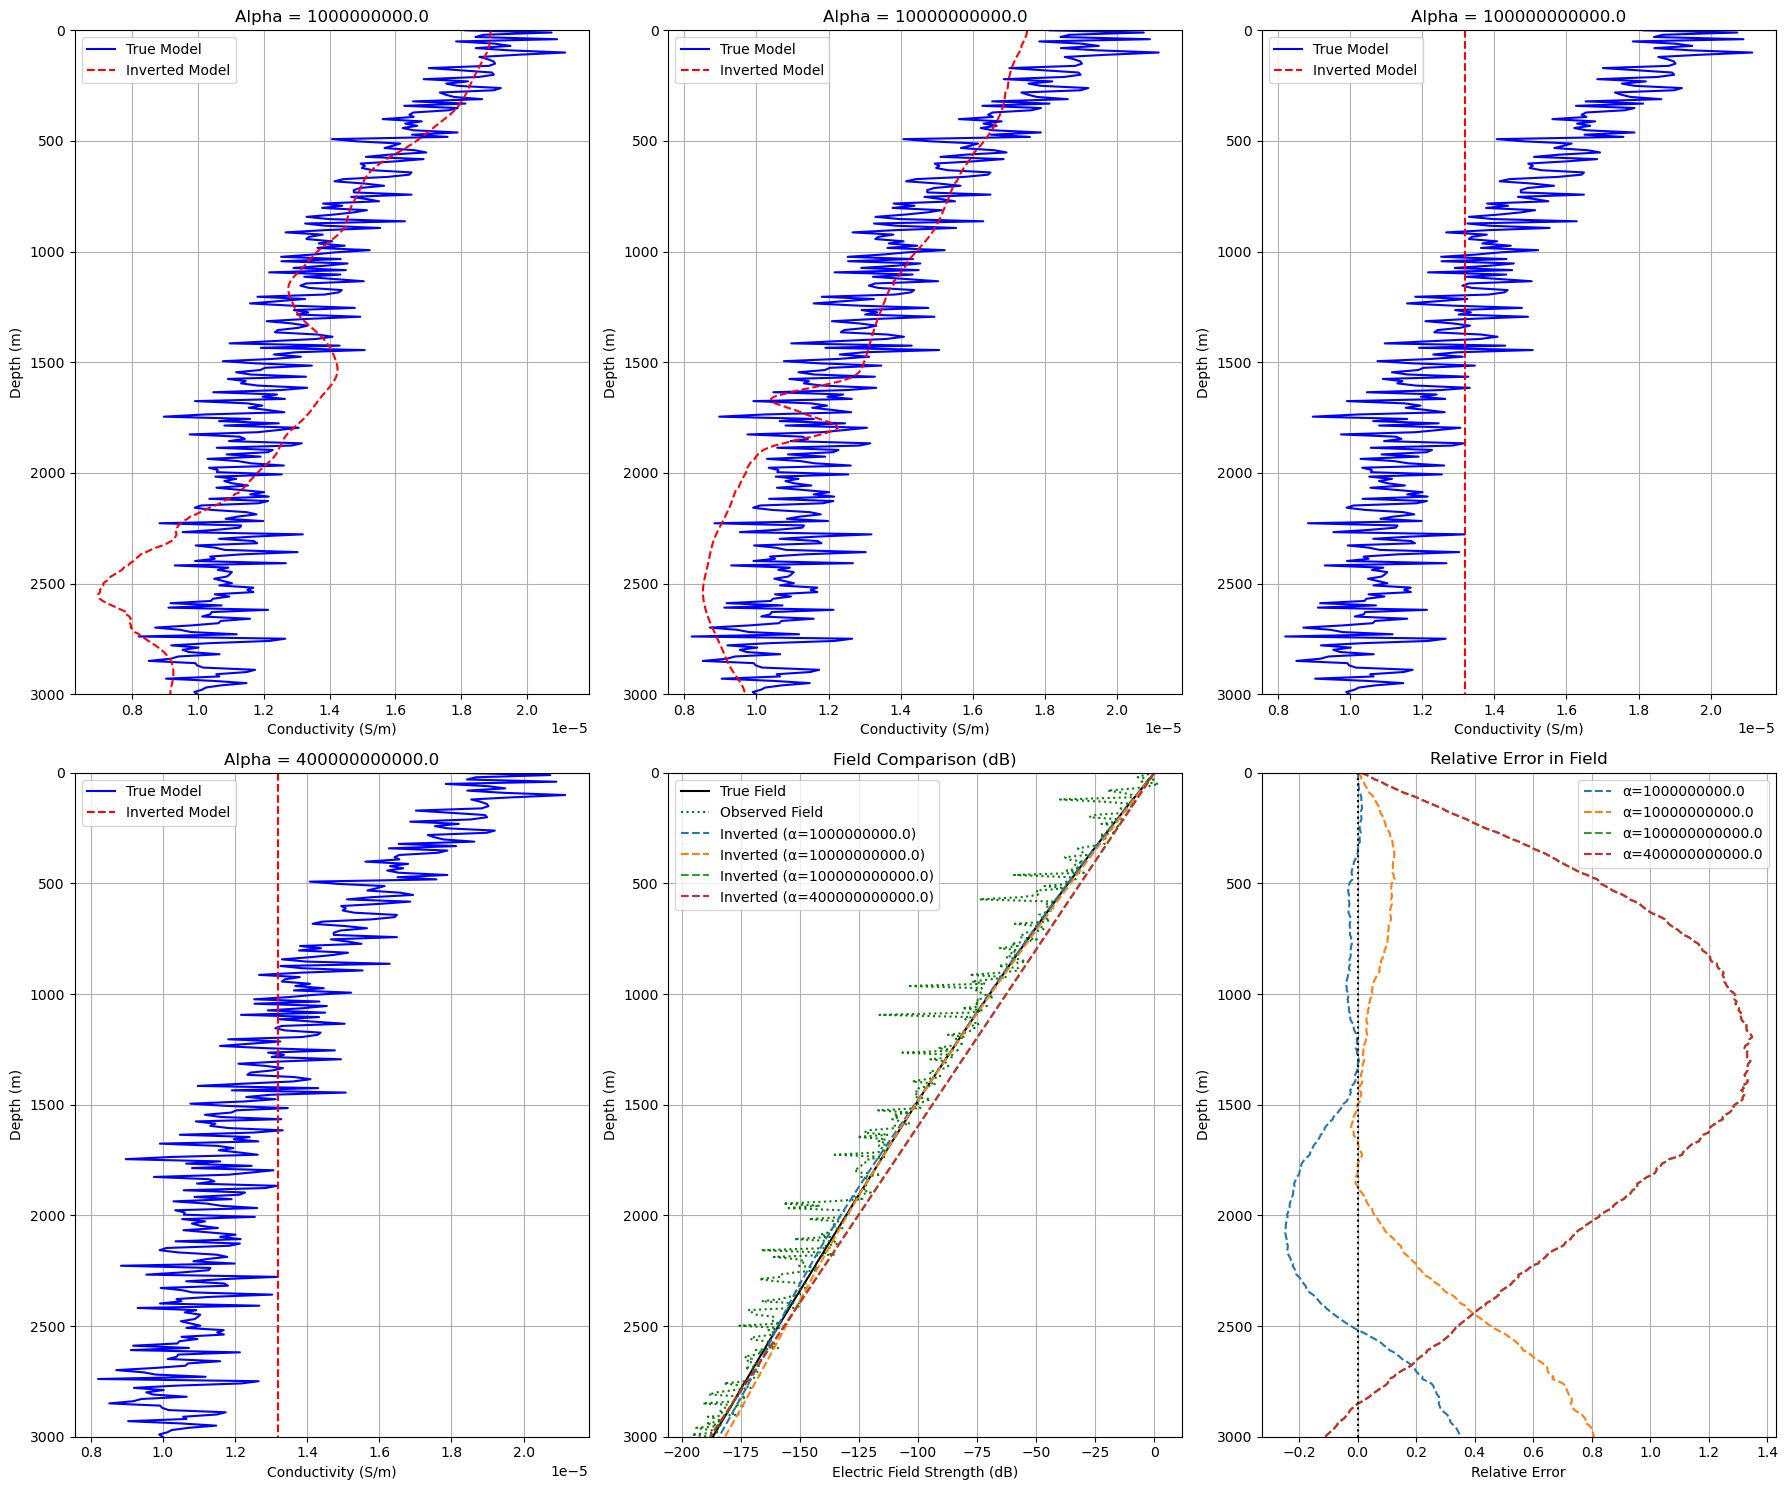

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 15))
axes = axes.ravel()

for i, (alpha, inverted_model) in enumerate(zip(alphas, inverted_models)):
    ax = axes[i]
    ax.plot(true_model, z, 'b-', label='True Model')
    ax.plot(inverted_model, z, 'r--', label='Inverted Model')
    ax.set_title(f'Alpha = {alpha}')
    ax.set_xlabel('Conductivity (S/m)')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim(depth, 0)
    ax.legend()
    ax.grid(True)
    #ax.set_xscale('log')

    # Calculate and print the root mean square error
    rmse = np.sqrt(np.mean((np.log10(true_model) - np.log10(inverted_model))**2))
    print(f"\nAlpha = {alpha}")
    print(f"Log10 RMSE: {rmse:.6f}")

# Add a new plot for field comparison in dB
ax = axes[4]
true_field = forward_model(true_model)
true_field_db = 20 * np.log10(true_field / true_field[0])
observed_field_db = 20 * np.log10(observed_field / observed_field[0])

ax.plot(true_field_db, z, 'k-', label='True Field')
ax.plot(observed_field_db, z, 'g:', label='Observed Field')

for alpha, inverted_model in zip(alphas, inverted_models):
    inverted_field = forward_model(inverted_model)
    inverted_field_db = 20 * np.log10(inverted_field / inverted_field[0])
    ax.plot(inverted_field_db, z, '--', label=f'Inverted (α={alpha})')

ax.set_title('Field Comparison (dB)')
ax.set_xlabel('Electric Field Strength (dB)')
ax.set_ylabel('Depth (m)')
ax.set_ylim(depth, 0)
ax.legend()
ax.grid(True)

# Add a plot for relative error
ax = axes[5]
for alpha, inverted_model in zip(alphas, inverted_models):
    inverted_field = forward_model(inverted_model)
    relative_error = (inverted_field - true_field) / true_field
    ax.plot(relative_error, z, '--', label=f'α={alpha}')
ax.set_title('Relative Error in Field')
ax.set_xlabel('Relative Error')
ax.set_ylabel('Depth (m)')
ax.set_ylim(depth, 0)
ax.legend()
ax.grid(True)
ax.axvline(0, color='k', linestyle=':')

plt.tight_layout()
plt.show()

# Integrating heat transfer physics into ray-based attenuation tomography

Additional to (or in place of) the smoothness constraint from regularization, we can actually integrate physics into the objective function via lagrange multiplier. Here as a demonstration, we can write out the objective functions in both 1D (along ice depth) and 2D (along depth and flow direction) cases:

For 1D case:

\begin{equation}
    J = \sum_0^H \text{log}_{10} \left(\frac{E_o e^{-\sum_0^q \alpha_i(\sigma) \Delta z} + \epsilon}{E_{obs} +  \epsilon}  \right)^2 + \alpha \sum_0^H \left(\frac{d \sigma}{dz}  \right)^2 + \beta \, \,  \underbrace{F\left[\int \left(w(z)\frac{dT}{dz} - \frac{k}{\rho c_p} \frac{d^2 T}{dz^2} + (u\phi - \dot{\epsilon \tau}) \right) dz \right]}_\text{physics}
\end{equation}


Here $F[...]$ represents the Arrhenius relationship that transforms temperature to ice electrical conductivity. The $u\phi - \dot{\epsilon} \tau$ term represents the source and sink of heat. 

In 2D we can write:

\begin{equation}
    J = \sum_{i=0}^H \sum_{m = 0}^L \text{log}_{10} \left(\frac{E_o e^{-\sum_0^q \alpha_{i,m}(\sigma) \Delta z} + \epsilon}{E_{obs; m} +  \epsilon}  \right)^2 + \alpha \sum_{i=0}^H \sum_{m=0}^L \left(\frac{d \sigma}{dz}  \right)^2 + \beta \, \,  \underbrace{F\left[\int_z \int x \left(w(z)\frac{\partial T}{\partial z} + u(x) \frac{\partial T}{\partial x}- \frac{k}{\rho c_p} \frac{\partial^2 T}{\partial z^2} - \dot{\epsilon \tau} \right) dx \, dz \right]}_\text{physics}
\end{equation}

The advantage of this 2D model is its potentially to account for the the complex heat structure meanwhile regulating the conductivity smoothness naturally.

**This objective minimization can be solved easily with Automatic Differentiation.**

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# derived constant
thermo_conduct = k/(rho_i*cp) # thermal diffusivity
z = torch.linspace(0, H, nz)
dz = z[1] - z[0]
# -----------------------------------------

class IceThermal:
    def __init__(self, H=1500.0, Ts=273.15 - 15, A=4.96e-25, a=0.2, L=40e3, u=300, dTdx=0):
        # Constants
        self.nz = 300  # number of depth points
        self.rho_i = 917  # kg m^-3
        self.cp = 2050  # J kg^-1 K^-1, specific heat capacity
        self.Tm = 273  # K
        self.n = 3  # Glen's flow law exponent
        self.k = 2.22  # W m^-1 K^-1, ice thermal conductivity
        self.G = 0.05  # W m^-2 (50 mW m^-2 geothermal heat flux)
        self.g = 9.8  # m/s^2

        # Frequency of the radar
        self.freq = 1e6  # 1 MHz
        self.omega = 2 * np.pi * self.freq

        # Synthetic temperature profile parameters as tensors
        self.H = torch.tensor(H, dtype=torch.float32, requires_grad=True)  # m
        self.Ts = torch.tensor(Ts, dtype=torch.float32, requires_grad=True)  # surface temperature
        self.A = torch.tensor(A, dtype=torch.float32, requires_grad=True)  # Pa^-3 s^-1, at 265K
        self.a = torch.tensor(a, dtype=torch.float32, requires_grad=True)  # m/a, surface accumulation rate
        self.L = torch.tensor(L, dtype=torch.float32, requires_grad=True)  # m, glacier length scale
        self.u = torch.tensor(u, dtype=torch.float32, requires_grad=True)  # m/a along flow velocity
        self.dTdx = torch.tensor(dTdx, dtype=torch.float32, requires_grad=True)  # deg C per m

        # Derived constant
        self.thermo_conduct = self.k / (self.rho_i * self.cp)  # thermal diffusivity
        self.z = torch.linspace(0, self.H.item(), self.nz)

    def calc_Pe(self):
        """Calculate Pe using the accumulation rate."""
        return self.rho_i * self.cp * self.a * self.H / self.k

    def T_to_conduct(self, T):
        """Calculate electrical conductivity from temperature."""
        Tr = 251  # kelvin
        sigma0 = 9.2e-6  # S/m
        E0 = 0.51 * 1.602e-19  # J
        k = 1.380e-23  # J/K, Boltzmann's constant

        # Arrhenius relation
        sigma = sigma0 * torch.exp(-(E0 / k) * (1 / T - 1 / Tr))
        return sigma

    def conduct_to_T(self, sigma):
        """Calculate temperature from electrical conductivity."""
        Tr = 251  # kelvin
        sigma0 = 9.2e-6  # S/m
        E0 = 0.51 * 1.602e-19  # J
        k = 1.380e-23  # J/K, Boltzmann's constant
        T = 1 / (1 / Tr - (k / E0) * torch.log(sigma / sigma0))
        return T

    def analy_hac_sol(self, phi, w, alpha):
        """Calculate analytical solution for heat conduction."""
        z = self.z
        H = self.H
        Ts = self.Ts
        Tm = self.Tm
        u = self.u

        coefA = (Tm - Ts - (u * phi * H) / w) / (1 - torch.exp(w * H / alpha))
        termB = (Ts - Tm * torch.exp(w * H / alpha) + u * phi * H / w) / (1 - torch.exp(w * H / alpha))
        return coefA * torch.exp(w * z / alpha) + termB - u * phi * z / w

    def analy_sol(self, w, alpha):
        """Calculate analytical solution for temperature profile."""
        z = self.z
        H = self.H
        Ts = self.Ts
        Tm = self.Tm

        numerator = (Ts - Tm) * torch.exp(-w * (z - H) / alpha) + Tm - Ts * torch.exp(w * H / alpha)
        denominator = 1 - torch.exp(w * H / alpha)
        return numerator / denominator


    
# Define EM-related functions --------------------------
import numpy as np
import torch

class AttenuationTomography:
    def __init__(self, omega, dz, initial_guess):
        self.omega = omega  # Frequency-related parameter
        self.dz = dz        # Depth increment
        self.initial_guess = initial_guess.clone().requires_grad_(True)  # Initial guess for conductivity

    def forward_model(self, conductivity):
        mu0 = 4 * np.pi * 1e-7  # Magnetic permeability of free space
        alpha = torch.sqrt(mu0 * self.omega * conductivity / 2)
        attenuation = torch.exp(-torch.cumsum(alpha, dim=0) * self.dz)
        return attenuation

    def objective(self, conductivity, observed, alpha):
        epsilon = 1e-11
        predicted = self.forward_model(conductivity)
        
        # Calculate data misfit
        data_misfit = (1 / predicted.size(dim=0)) * torch.sum((torch.log10(predicted + epsilon) - torch.log10(observed + epsilon)) ** 2)
        
        # Calculate smoothness
        smoothness = alpha * torch.sum(torch.diff(conductivity) ** 2)

        # Normalize terms
        data_misfit = data_misfit / (1 + data_misfit)  # Prevent division by zero

        return data_misfit + smoothness

    def heat_transfer_analytc_loss(self, u, z, Pe):
        z.requires_grad = True
        u_z = torch.autograd.grad(u.sum(), z, create_graph=True)[0]
        u_zz = torch.autograd.grad(u_z.sum(), z, create_graph=True)[0]
        deq = Pe * u_z + u_zz
        return deq

    def objective_plus_physics(self, conductivity, observed, alpha, beta, gamma, Tm, Ts):
        epsilon = 1e-11
        predicted = self.forward_model(conductivity)
        
        # Calculate data misfit
        data_misfit = (1 / predicted.size(dim=0)) * torch.sum((torch.log10(predicted + epsilon) - torch.log10(observed + epsilon)) ** 2)
        
        # Add physics
        T = self.conduct_to_T(conductivity)  # Assuming this method exists
        physics_loss = beta * self.heat_transfer_analytc_loss(T, z, Pe)  # Assuming z and Pe are defined
        
        # Add boundary condition loss
        Ts_pred = self.conduct_to_T(conductivity[-1])
        Tm_pred = self.conduct_to_T(conductivity[0])
        
        BC_loss = gamma * (torch.abs(Tm_pred - Tm) + torch.abs(Ts_pred - Ts))
        
        # Calculate smoothness
        smoothness = alpha * torch.sum(torch.diff(conductivity) ** 2)
        
        # Normalize terms
        data_misfit = data_misfit / (1 + data_misfit)  # Prevent division by zero

        return data_misfit + smoothness + physics_loss + BC_loss

    def invert(self, alpha, beta, gamma, observed):
        conductivity = self.initial_guess.clone().requires_grad_(True)
        optimizer = torch.optim.Adam([conductivity], lr=1e-6)

        for iteration in range(500):  # Number of iterations
            optimizer.zero_grad()
            loss = self.objective(conductivity, observed, alpha)

            lambda_reg = 1e5  # Small constant for regularization
            loss += lambda_reg * torch.sum(conductivity ** 2)

            if torch.isnan(loss):
                print(f"NaN detected in loss calculation. This is iteration {iteration}")
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_([conductivity], max_norm=1.0)  # Adjust max_norm as needed
            
            optimizer.step()
            
            # Optionally print the loss for monitoring
            if iteration % 100 == 0:
                print(f"Iteration {iteration}, Loss: {loss.item()}")

        return conductivity.detach().numpy()


# Utility--------------------------------------
# Replace NaN values with the average of the 10 nearest non-NaN values
def sec_to_yr(u):
    # convert ()/s to ()/a, meaning per second to per year
    return u*3.154e7

def yr_to_sec(u):
    # convert ()/a to ()/s
    return u/(3.154e7)

def replace_nans_with_neighbors(observed_field, num_neighbors=10):
    for i in range(nz):
        if torch.isnan(observed_field[i]):
            # Get the indices of the neighbors
            left_indices = range(max(0, i - num_neighbors), i)
            right_indices = range(i + 1, min(nz, i + num_neighbors + 1))
            
            # Collect valid neighbor values
            neighbor_values = []
            for idx in left_indices:
                if not torch.isnan(observed_field[idx]):
                    neighbor_values.append(observed_field[idx])
            for idx in right_indices:
                if not torch.isnan(observed_field[idx]):
                    neighbor_values.append(observed_field[idx])
            
            # Calculate the average of valid neighbors
            if neighbor_values:
                observed_field[i] = torch.mean(torch.tensor(neighbor_values, dtype=torch.float32))
            

/tmp/xpython_9355/2448760377.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32)
/tmp/xpython_9355/2448760377.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32)


Text(0.5, 0, 'Conductivity (S/m)')

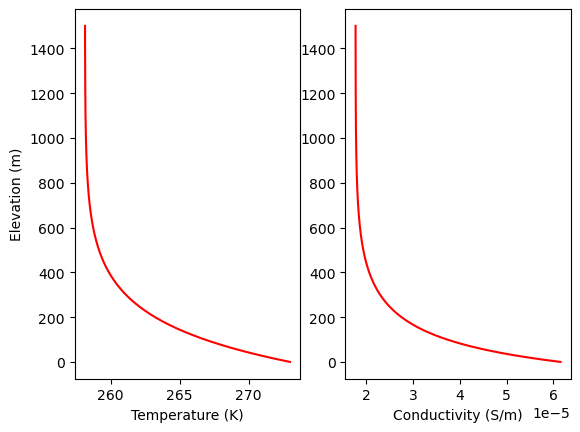

In [3]:
# get synthetic temperature profile
T_hac = analy_hac_sol(z, H, Ts, Tm, yr_to_sec(u), dTdx, -yr_to_sec(a), thermo_conduct)
T_ori = analy_sol(z, H, Ts, Tm, yr_to_sec(a), thermo_conduct) # without horizontal advection

# get conductivity structure
true_model = T_to_conduct(T_hac)

fig, ax = plt.subplots(1,2)
ax[0].plot(T_hac, z,'r')
ax[0].set_ylabel('Elevation (m)')
ax[0].set_xlabel('Temperature (K)')

ax[1].plot(true_model, z,'r')
ax[1].set_xlabel('Conductivity (S/m)')

/tmp/xpython_9355/2794860373.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_field = forward_model(torch.tensor(true_model, dtype=torch.float32))


tensor(-1.0735)


Text(0, 0.5, 'Depth from ice surface (m)')

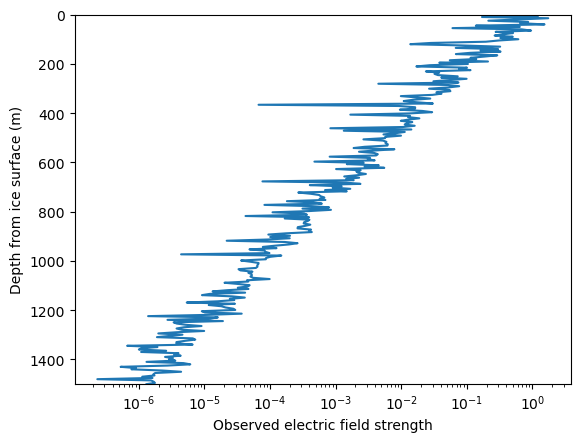

In [4]:
# add 'noise' to conductivity structure (represents the ice chemistry variability)
true_model = true_model + 1e-6 * np.random.randn(nz)

# Generate synthetic observed data (with some noise)
true_field = forward_model(torch.tensor(true_model, dtype=torch.float32))
noise_level = 0.9  # 50% noise
observed_field = true_field * (1 + noise_level * torch.randn(nz))
print(torch.sum(observed_field[observed_field <= 0]))
observed_field[observed_field <= 0] = float('nan')

# Call the function to replace NaNs
replace_nans_with_neighbors(observed_field)

# Plot observed field
fig, ax = plt.subplots()
ax.semilogx(observed_field.numpy(), z)
ax.set_ylim(H, 0)
ax.set_xlabel('Observed electric field strength')
ax.set_ylabel('Depth from ice surface (m)')



/tmp/xpython_9355/133149505.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_guess = torch.ones(nz) * torch.mean(torch.tensor(true_model, dtype=torch.float32))
/tmp/xpython_9355/2448760377.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = objective(conductivity, torch.tensor(observed_field, dtype=torch.float32).clone().detach(), alpha)


Iteration 0, Loss: 0.14804890751838684
L2 reg: 0.015133065171539783
Gradient norm after clipping: 0.9999999403953552
Iteration 400, Loss: 0.11782801151275635
L2 reg: 0.015506983734667301
Gradient norm after clipping: 0.9999999403953552
Iteration 0, Loss: 0.14804890751838684
L2 reg: 0.015133065171539783
Gradient norm after clipping: 0.9999999403953552
Iteration 400, Loss: 0.12286636978387833
L2 reg: 0.014591556042432785
Gradient norm after clipping: 1.0
Iteration 0, Loss: 0.14804890751838684
L2 reg: 0.015133065171539783
Gradient norm after clipping: 0.9999999403953552
Iteration 400, Loss: 0.13383136689662933
L2 reg: 0.01457646582275629
Gradient norm after clipping: 1.0
Iteration 0, Loss: 0.14804890751838684
L2 reg: 0.015133065171539783
Gradient norm after clipping: 0.9999999403953552
Iteration 400, Loss: 0.14386455714702606
L2 reg: 0.014739376492798328
Gradient norm after clipping: 1.0


/tmp/xpython_9355/133149505.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_field = forward_model(torch.tensor(true_model, dtype=torch.float32))
/tmp/xpython_9355/133149505.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observed_field_db = 20 * torch.log10(torch.tensor(observed_field, dtype=torch.float32) / observed_field[0])


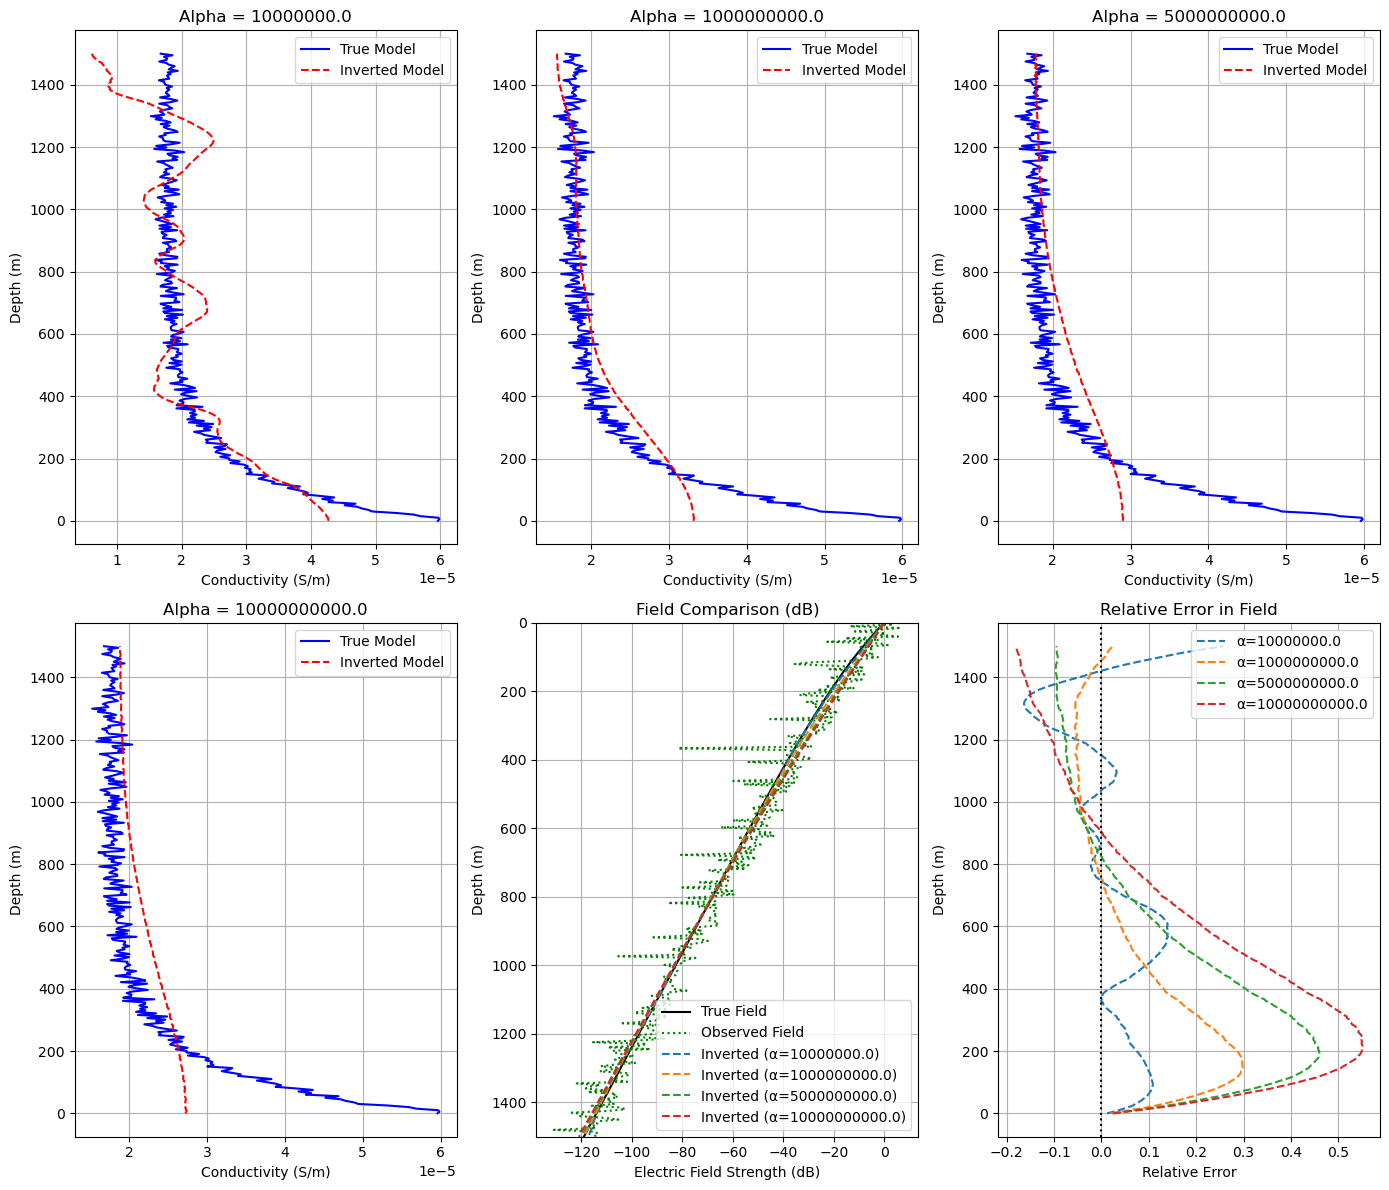

In [12]:
# Inversion
initial_guess = torch.ones(nz) * torch.mean(torch.tensor(true_model, dtype=torch.float32))

# Try different alpha values
alphas = [1e7, 1e9, 5e9, 1e10]
beta = 1e5
gamma = 1e5
inverted_models = [invert(alpha, beta, gamma) for alpha in alphas]

# Plotting results
fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.ravel()

for i, (alpha, inverted_model) in enumerate(zip(alphas, inverted_models)):
    ax = axes[i]
    ax.plot(true_model, z, 'b-', label='True Model')
    ax.plot(inverted_model, z, 'r--', label='Inverted Model')
    ax.set_title(f'Alpha = {alpha}')
    ax.set_xlabel('Conductivity (S/m)')
    ax.set_ylabel('Depth (m)')
    #ax.set_ylim(H, 0)
    ax.legend()
    ax.grid(True)

    # # Calculate and print the root mean square error
    # rmse = np.sqrt(np.mean((np.log10(true_model) - np.log10(inverted_model)) ** 2))
    # print(f"\nAlpha = {alpha}")
    # print(f"Log10 RMSE: {rmse:.6f}")

# Add a new plot for field comparison in dB
ax = axes[4]
true_field = forward_model(torch.tensor(true_model, dtype=torch.float32))
true_field_db = 20 * torch.log10(true_field / true_field[0])
observed_field_db = 20 * torch.log10(torch.tensor(observed_field, dtype=torch.float32) / observed_field[0])

ax.plot(true_field_db.numpy(), z, 'k-', label='True Field')
ax.plot(observed_field_db.numpy(), z, 'g:', label='Observed Field')

for alpha, inverted_model in zip(alphas, inverted_models):
    inverted_field = forward_model(torch.tensor(inverted_model, dtype=torch.float32))
    inverted_field_db = 20 * torch.log10(inverted_field / inverted_field[0])
    ax.plot(inverted_field_db.numpy(), z, '--', label=f'Inverted (α={alpha})')

ax.set_title('Field Comparison (dB)')
ax.set_xlabel('Electric Field Strength (dB)')
ax.set_ylabel('Depth (m)')
ax.set_ylim(H, 0)
ax.legend()
ax.grid(True)

# Add a plot for relative error
ax = axes[5]
for alpha, inverted_model in zip(alphas, inverted_models):
    inverted_field = forward_model(torch.tensor(inverted_model, dtype=torch.float32))
    relative_error = (inverted_field - true_field) / true_field
    ax.plot(relative_error.numpy(), z, '--', label=f'α={alpha}')
ax.set_title('Relative Error in Field')
ax.set_xlabel('Relative Error')
ax.set_ylabel('Depth (m)')
#ax.set_ylim(H, 0)
ax.legend()
ax.grid(True)
ax.axvline(0, color='k', linestyle=':')

plt.tight_layout()
plt.savefig("plots/inverted_E_sigma_compare.png", dpi = 300, bbox_inches="tight")

plt.show()

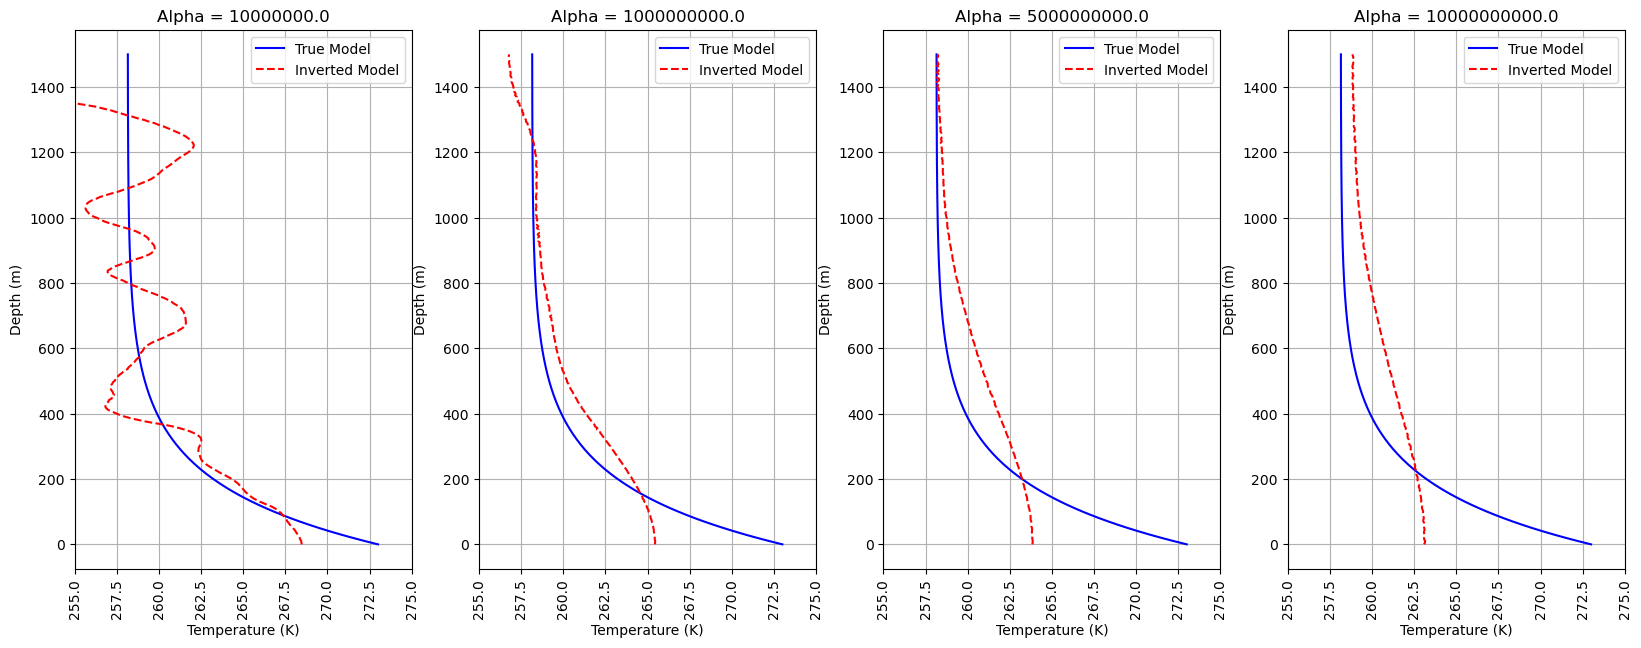

In [13]:
# Plotting results
fig, axes = plt.subplots(1, 4, figsize=(20, 7))
axes = axes.ravel()

for i, (alpha, inverted_model) in enumerate(zip(alphas, inverted_models)):
    ax = axes[i]
    ax.plot(T_hac, z, 'b-', label='True Model')
    ax.plot(conduct_to_T(torch.tensor(inverted_model)), z, 'r--', label='Inverted Model')
    ax.tick_params(axis='x',rotation=90)
    ax.set_title(f'Alpha = {alpha}')
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(255, 275)
    ax.legend()
    ax.grid(True)

    # # Calculate and print the root mean square error
    # rmse = np.sqrt(np.mean((np.log10(true_model) - np.log10(inverted_model)) ** 2))
    # print(f"\nAlpha = {alpha}")
    # print(f"Log10 RMSE: {rmse:.6f}")

plt.savefig("plots/inverted_T_compare.png", dpi = 300, bbox_inches="tight")